<a href="https://colab.research.google.com/github/Lucien0907/sr_perceptual/blob/master/model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data preparation

In [0]:
from os import listdir, makedirs
from os.path import isfile, join, exists
from google.colab import drive

import cv2
import h5py
import random
import numpy as np
import imageio
import scipy.io as sio
import matplotlib.pyplot as plt
from skimage.filters import gaussian
from sklearn.feature_extraction import image

## a. Load previously saved data

In [0]:
drive.mount('/content/drive')
%cd 'drive/My Drive/sr_perceptual'

In [0]:
with h5py.File('data/data_train_val.h5', 'r') as hf:
    x_train = hf['x_train'][:]
    y_train = hf['y_train'][:]
    x_valid = hf['x_valid'][:]
    y_valid = hf['y_valid'][:]
with h5py.File('data/data_test_set14.h5', 'r') as hf:
    x_test = hf['x_test'][:]
    y_test = hf['y_test'][:]
print('x_train', x_train.shape, 'y_train', y_train.shape, 'x_valid', 
      x_valid.shape, 'y_valid', y_valid.shape, 'x_test', x_test.shape, 'y_test', y_test.shape)

## b. Generate new data

### Generate training data

In [0]:
mypath='/home/lucien/sr-perceptual/data/train2014'
onlyfiles = [ f for f in listdir(mypath) if f.endswith('.jpg')]
onlyfiles = random.sample(onlyfiles, 11000)

y_train = []
x_train = []

for n in range(0, len(onlyfiles)):
  img = imageio.imread(join(mypath,onlyfiles[n]))
  if img.ndim < 3:
        img = np.array([img,img,img]).reshape(img.shape[0],img.shape[1],3)
  delta_h = max(0, 288-img.shape[0])
  delta_w = max(0, 288-img.shape[1])
  top = delta_h//2
  bottom = delta_h-top
  left = delta_w//2
  right = delta_w-left
  new_img = np.pad(img,((top,bottom),(left,right),(0,0)), 'constant', )
  patches = image.extract_patches_2d(new_img, (288, 288), max_patches=1)
  for x in patches:
    y_train.append(x)
    gauss = cv2.GaussianBlur(x, (0, 0), 1)
    bicubic = cv2.resize(gauss,(72,72), interpolation = cv2.INTER_CUBIC)
    x_train.append(bicubic)

x_train=np.asarray(x_train)
y_train=np.asarray(y_train)

x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=1000, shuffle= True)


FileNotFoundError: ignored

In [0]:
n=5
fig, ax = plt.subplots(1, 2)
ax[0].imshow(y_train[1*n])
ax[0].axis('off')
ax[1].imshow(x_train[1*n])
ax[1].axis('off')
plt.show()

In [0]:
with h5py.File('data_train_new.h5', 'w') as hf:
    hf.create_dataset('x_train', data=x_train)
    hf.create_dataset('y_train', data=y_train)

### Generating test data

In [0]:
mypath='/home/lucien/sr-perceptual/data/Set14'
onlyfiles = [ f for f in listdir(mypath) if f.endswith('.png') ]

y_test = []
x_test = []

for n in range(0, len(onlyfiles)):
  img = imageio.imread(join(mypath,onlyfiles[n]))
  if img.ndim < 3:
    img = np.array([img,img,img]).reshape(img.shape[0],img.shape[1],3)
  delta_h = max(0, 288-img.shape[0])
  delta_w = max(0, 288-img.shape[1])
  top = delta_h//2
  bottom = delta_h-top
  left = delta_w//2
  right = delta_w-left
  new_img = np.pad(img,((top,bottom),(left,right),(0,0)), 'constant', )
  patches = image.extract_patches_2d(new_img, (288, 288), max_patches=1)
  for x in patches:
    y_test.append(x) 
    gauss = cv2.GaussianBlur(x, (0, 0), 1)
    bicubic = cv2.resize(gauss,(72,72), interpolation = cv2.INTER_CUBIC)
    x_test.append(bicubic)
    
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

(14, 288, 288, 3)
(14, 72, 72, 3)


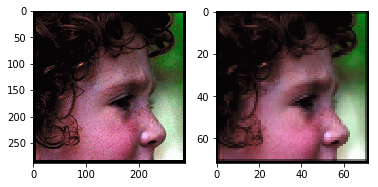

In [0]:
print(np.shape(y_test))
print(np.shape(x_test))
n = 5
plt.subplot(1,2,1)
plt.imshow(y_test[n])
plt.subplot(1,2,2)
plt.imshow(x_test[n])

In [0]:
with h5py.File('data_test_set14_new.h5', 'w') as hf:
    hf.create_dataset('x_test', data=x_test)
    hf.create_dataset('y_test', data=y_test)

# 2. Helper functions for building transformation network

In [0]:
from __future__ import division

import six
import os
import cv2
import keras
import math

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.engine.topology import Layer
from keras.layers import Input, Activation, Dense, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D, AveragePooling2D
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model
from keras.applications.vgg16 import VGG16
from skimage.measure import compare_psnr, compare_ssim

In [0]:
def _bn_relu(input):
    """Helper to build a BN -> relu block"""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _bn_tanh(input):
    """Helper to build a BN -> relu block"""
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("tanh")(norm)

def _conv_bn_tanh(**conv_params):
    """Helper to build a conv -> BN -> relu block"""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_tanh(conv)

    return f

def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block"""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f

def _conv_trans_bn_relu(**conv_params):
    """Helper to build a conv_trans -> BN -> relu block"""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (2, 2))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2DTranspose(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f

def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf"""
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f

def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])

def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks."""
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            #if i == 0 and not is_first_layer:
            #    init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f

def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf"""
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f

def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4"""
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f

def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class Denormalize(Layer):
    '''
    Custom layer to denormalize the final Convolution layer activations (tanh)
    Since tanh scales the output to the range (-1, 1), we add 1 to bring it to the
    range (0, 2). We then multiply it by 127.5 to scale the values to the range (0, 255)
    '''

    def __init__(self, **kwargs):
        super(Denormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        '''
        Scales the tanh output activations from previous layer (-1, 1) to the
        range (0, 255)
        '''
        
        return (x + 1) * 127.5

    def get_output_shape_for(self, input_shape):
        return input_shape


            
def normalize(x):
    return (x.astype('float32')/127.5)-1
  
def interp(x):
    x_temp=np.empty((len(x), 288, 288, 3))
    for i in range(len(x)):
      x_temp[i,] = cv2.resize(x[i],(288,288), interpolation = cv2.INTER_CUBIC)
    return x_temp
  
def denormalize(x):
    return np.uint8((x+1)*127.5)
            
def get_psnr(img1, img2, MAX):
    mse = np.mean((img1-img2)**2)
    return 10*math.log10( MAX**2 / mse )

def get_psnr_mean(batch1, batch2, MAX):
    psnrs = [ get_psnr(batch1[i], batch2[i], MAX) for i in range(len(batch1)) ]
    mean = sum(psnrs)/len(psnrs)
    return psnrs, mean

def get_ychannel(img):
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    return img_ycrcb[:,:,0]
  
def get_ychannel_batch(batch):
  ychs = [ get_ychannel(x) for x in batch ]
  return np.asarray(ychs)

def val_psnr_ssim(x, y, model, layer_index):
  mainModel = Model(fullModel.input, fullModel.layers[layer_index].output)
  psnr_temp, ssim_temp = [], []
  for i in range(len(x)):
    if mainModel.input.shape[1] == 288:
      x_temp = normalize(interp(x[i:i+1]))
    else:
      x_temp = normalize(x[i:i+1])
    x_out = np.uint8( mainModel.predict_on_batch(x_temp)[0] )
    x_out_ych = get_ychannel(x_out)
    y_ych = get_ychannel(y_valid[i])
    psnr_temp.append( get_psnr(y_ych, x_out_ych, 255) )
    ssim_temp.append( compare_ssim(y_ych, x_out_ych, data_range=255) )
    psnr_mean = sum(psnr_temp)/len(psnr_temp)
    ssim_mean = sum(ssim_temp)/len(ssim_temp)
  return psnr_mean, ssim_mean

def new_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred)))/82944

def nrmse_relu1_2(y_true, y_pred):
    # relu_1-2: 5308416 relu_2-2: 2654208 relu_3-3: 1327104
    return K.sqrt(K.sum(K.square(y_pred - y_true)))/5308416

def nrmse_relu2_2(y_true, y_pred):
    # relu_1-2: 5308416 relu_2-2: 2654208 relu_3-3: 1327104
    return K.sqrt(K.sum(K.square(y_pred - y_true)))/2654208

def nrmse_relu3_3(y_true, y_pred):
    # relu_1-2: 5308416 relu_2-2: 2654208 relu_3-3: 1327104
    return K.sqrt(K.sum(K.square(y_pred - y_true)))/1327104

def per_pixel(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true)))/248832
  
def model_load(model_name, output_layer):
    fullModel_test = load_model(model_name, custom_objects={'nrmse': nrmse, 'Denormalize' : Denormalize})
    mainModel_test = Model(fullModel_test.input, fullModel_test.layers[output_layer].output)
    return mainModel_test

def test_model(img_test, model, model_type, layer_index): 
    if model_type == 'full':
        mainModel_temp = Model(model.input, model.layers[layer_index].output)
    elif model_type == 'main':
        mainModel_temp = model
    x_interp = cv2.resize(img_test,(288,288), interpolation = cv2.INTER_CUBIC)
    if mainModel_temp.input_shape[1] == 288:
        x = x_interp
    else:
        x = img_test
    x = (x.astype('float32')/127.5)-1
    img = np.array(x)[np.newaxis,:,:,:]
    y = mainModel_temp.predict_on_batch(img)
    return x_interp, y[0]

def kernel_init(shape):
    kernel = np.zeros(shape)
    kernel[:,:,0,0] = np.array([[0,-0.25,0],[-0.25,1,-0.25],[0,-0.25,0]])
    return kernel
  
class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        # Architecture starts
        input = Input(shape=input_shape)
        block = _conv_bn_relu(filters=64, kernel_size=(9, 9), strides=(1, 1))(input)
        
        # Residual blocks
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=64, repetitions=r, is_first_layer=(i == 0))(block)
            
        # Last few layers
        block = _conv_trans_bn_relu(filters=64, kernel_size=(3, 3), strides=(2, 2))(block)
        block = _conv_trans_bn_relu(filters=64, kernel_size=(3, 3), strides=(2, 2))(block)
        block = _conv_bn_tanh(filters=3, kernel_size=(9, 9), strides=(1, 1))(block)
        block = Denormalize(name='denorm_output')(block)
        model = Model(inputs=input, outputs=block)
        
        
        return model

class SRCNN(object):
    @staticmethod
    def build(input_shape):
        """Builds a three layer single-image super resolution network
        """
        input = Input(shape=input_shape)
        block = Conv2D(64, (9, 9), padding='same', activation='relu', kernel_initializer='he_normal')(input)
        block = Conv2D(32, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(block)
        block = Conv2D(3, (5, 5), padding='same',activation='tanh', kernel_initializer='he_normal')(block)
        block = Denormalize(name='denorm_output')(block)
        model = Model(inputs=input, outputs=block)
        return model

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, x_train, y_train, input_shape, lossModel=None, batch_size=4, shuffle=True):
        'Initialization'
        self.x_train = x_train
        self.y_train = y_train
        self.input_shape = input_shape
        self.lossModel = lossModel
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.x_train) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate  batch of data
        idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x = self.x_train[idx,]
        
        # Interpolation for SRCNN, as input is required in the shape (288,288,3)
        if self.input_shape[1] == 288:
          x = interp(x)
        x = normalize(x)
        
        # Apply lossModel for perceptual loss
        if self.lossModel == None:
          y = self.y_train[idx,]
        else:
          y = self.lossModel.predict_on_batch(self.y_train[idx,])
        
        # For regularization
        #y_trains = {
        #    "model_3": y_train[idx,],
        #    "model_2": y
        #}
        
        return x, y
      
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.x_train))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
      

# 3. Configure the model

In [0]:
### Specify model name and some hyperparameters settings, create directories for saving data
model_dir = "SRCNN_perceptual_Relu2-2"
model_path = model_dir + "/models"
output_path = model_dir + "/outputs"
test_path = model_dir + "/tests"
output_layer = "Relu2-2"
loss_layer = 5          # Relu1-2: 2  Relu2-2: 5 Relu3-3: 9 
loss_model_file = model_dir + "/" + model_dir + "_lossModel_" + output_layer + ".h5"
batch_size = 4 
layer_index = 46        # 4 for SRCNN, 46 for ResNet

if not exists(model_dir):
    makedirs(model_dir)
    makedirs(model_dir+"/models")
    makedirs(model_dir+"/outputs")
    makedirs(model_dir+"/tests")

## a. Build new model


### Create model with per-pixel loss

In [0]:
### Create Image Transformation Model ###
#fullModel = SRCNN.build((288,288,3))
fullModel = ResnetBuilder.build((3,72,72), 5, basic_block, [1, 1, 1, 1, 1])
#fullModel.summary()
plot_model(fullModel, to_file= model_dir + '/' + model_dir + '_fullModel_' + output_layer + '.png', show_shapes=True)

### Compile FUll Model
fullModel.compile(loss=per_pixel, optimizer='adam',metrics=['mse'])
trained_epochs=0
train_loss, valid_loss, PSNR, SSIM = [], [], [], []
print("Model_" + model_dir + "_" + output_layer + " compiled!")

### Create model with perceptual loss

In [0]:
### Create Image Transformation Model ###
#mainModel = SRCNN.build((288,288,3))
mainModel = ResnetBuilder.build((3,72,72), 5, basic_block, [1, 1, 1, 1, 1])
#mainModel.summary()
plot_model(mainModel, to_file= model_dir + '/' + model_dir + '_mainModel.png', show_shapes=True)

### Create Loss Model (VGG16) ###
lossModel = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(288,288,3))
lossModel.trainable=False
for layer in lossModel.layers:
    layer.trainable=False
#lossModel.summary()
plot_model(lossModel, to_file= model_dir + '/' + 'VGG16.png', show_shapes=True)
### Create New Loss Model (Use certain layer output for perceptual loss)
lossModel = Model(lossModel.inputs,lossModel.layers[loss_layer].output)
lossModelOutputs = lossModel(mainModel.output)
lossModel.save(model_dir + '/' + model_dir + '_lossModel_' + output_layer + '.h5')
#lossModel.summary()
plot_model(lossModel, to_file= model_dir + '/' + model_dir + '_lossModel_' + output_layer + '.png', show_shapes=True)

a = Input(shape=(288,288,3))
b = Conv2D(filters=1, name='reg_output', kernel_size=(3,3), strides=1, padding='same', kernel_initializer=kernel_init, trainable=False)(a)
regModel = Model(inputs=a, outputs=b)
regModelOutputs=regModel(mainModel.output)
                
### Create Full Model ###
fullModel = Model(mainModel.input, [lossModelOutputs, regModelOutputs])
fullModel.summary()
plot_model(fullModel, to_file= model_dir + '/' + model_dir + '_fullModel_' + output_layer + '.png', show_shapes=True)

### For regularization ###
#loss_funcs = {
#        "model_3": new_loss,
#        "model_2": nrmse_relu2_2
#}
#loss_weights = {"model_3": 1.0, "model_2": 1.0}

### Compile FUll Model
fullModel.compile(loss=nrmse_relu2_2, loss_weights=loss_weights, optimizer='adam')
lossModel.predict(np.zeros((2, 288,288,3)))
trained_epochs=0
train_loss, valid_loss, PSNR, SSIM = [], [], [], []
print("Model_" + model_dir + "_" + output_layer + " compiled!")

## b. Load pretrained model


In [0]:
trained_epochs=78
fullModel = load_model(model_path + "/" + model_dir + "_epoch" + str(trained_epochs)+".h5", custom_objects={'nrmse_relu3_3': nrmse_relu3_3, 'Denormalize': Denormalize} )
lossModel = load_model(loss_model_file, custom_objects={'nrmse_relu3_3': nrmse_relu3_3} )
lossModel.predict(np.zeros((2, 288,288,3)))
with h5py.File(model_path+"/"+model_dir+"_loss_and_metric.h5", 'r') as hf:
    train_loss = hf['train_loss'][:].tolist()
    valid_loss = hf['valid_loss'][:].tolist()
    PSNR = hf['PSNR'][:].tolist()
    SSIM = hf['SSIM'][:].tolist()
print("Model and training record loaded", len(PSNR), len(train_loss) )

# 4. Training

In [0]:
# Configure data generator
train_generator = DataGenerator(x_train[:], y_train[:], input_shape=fullModel.input.shape, lossModel=lossModel, batch_size=batch_size, shuffle=True)
valid_generator = DataGenerator(x_valid[:], y_valid[:], input_shape=fullModel.input.shape, lossModel=lossModel, batch_size=1, shuffle=True)

In [0]:
# Train model on dataset 2
epochs=5
for epoch in range(trained_epochs+1,trained_epochs+epochs+1):
    ### Training
    hist = fullModel.fit_generator(generator=train_generator, validation_data=valid_generator, validation_steps=len(x_valid[:]), 
                                   epochs=epoch, initial_epoch=epoch-1, workers=6, use_multiprocessing=False )
    train_loss.append(hist.history['loss'])
    valid_loss.append(hist.history['val_loss'])
    
    ### Compute and record PSNR & SSIM
    psnr_mean, ssim_mean = val_psnr_ssim(x_valid[:], y_valid[:], fullModel, layer_index)
    PSNR.append(psnr_mean)
    SSIM.append(ssim_mean)
    if len(train_loss) == len(valid_loss) == len(PSNR) == len(SSIM):
      print( "PSNR_", PSNR[epoch-1], "SSIM", SSIM[epoch-1] )
    
    ### Save losses and metrics
    with h5py.File(model_path+"/"+model_dir+"_loss_and_metric.h5", 'w') as hf:
      hf.create_dataset('train_loss', data=train_loss)
      hf.create_dataset('valid_loss', data=valid_loss)
      hf.create_dataset('PSNR', data=PSNR)
      hf.create_dataset('SSIM', data=SSIM)
    
    ### Record output for single test image
    if epoch%1==0:
      fullModel.save(model_path + "/" + model_dir + "_epoch" + str(epoch)+'.h5')
      x, y = test_model(x_test[4], fullModel, 'full', layer_index)
      imageio.imwrite(output_path + "/" + model_dir + "_epoch" + str(epoch)+'.png', np.uint8(y))
      
trained_epochs=trained_epochs + epochs

# 5. Testing

In [0]:
model_name = model_path + "/" + model_dir + "_epoch" + str(trained_epochs)+'.h5'
fullModel_test = load_model(model_name, custom_objects={'nrmse': nrmse, 'Denormalize' : Denormalize})
mainModel_test = Model(fullModel_test.input, fullModel_test.layers[output_layer].output)

In [0]:
for i in range(len(x_test)):
    print("Test "+str(i+1), end=" ")
    x, out = test_model(x_test[i], fullModel, 'full', layer_index)
    imageio.imwrite(test_path + "/test" + str(i+1) + '_low.png', x)
    imageio.imwrite(test_path + "/test" + str(i+1) + '_ground.png', y_test[i])
    imageio.imwrite(test_path + "/test" + str(i+1) + '_out_' + model_dir + '_epoch' + str(trained_epochs) + '.png', np.uint8(out))